<a href="https://colab.research.google.com/github/Lucas-Buk/Machine-Learning-Metodos-Prob/blob/main/Aula_04_Generative_Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generative Models**

*What I cannot create, I do not understand* -  Richard Fyenman (Nobel, 1965)

https://www.nobelprize.org/prizes/physics/1965/feynman/lecture/


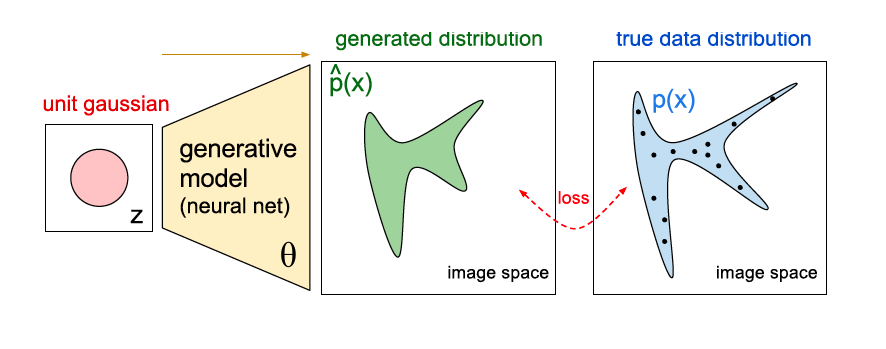

**Créditos: https://openai.com/about/**

# **Bibliotecas e instalações**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from matplotlib import cm # Colormaps
from matplotlib.patches import Ellipse

from sklearn.mixture import GaussianMixture

# **Funções proprietárias**

## Gaussians unidimensional e bidimensional

In [2]:
def Gaussiana_1D(x, mean, variance):
   
    return ((1. / np.sqrt(2 * np.pi * variance)) * 
            np.exp(-(x - mean)**2 / (2 * variance)))

In [3]:
def multivariate_normal(x, d, mean, covariance):
    
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

## Superfície Gaussiana

In [4]:
# Plot bivariate distribution
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x1[i,j]], [x2[i,j]]]), 
                d, mean, covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)


## Geração de elipses para o resultado do GMM

In [5]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
   
    ax = ax or plt.gca()
    
    # Rotaciona o conjunto de dados para alinhamento com a convariância
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Cria e elipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

## Visualização dos digitos

In [6]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)

# **Aprendizado**

### **Gaussiana unidimensional**

$$ \mathcal{N}(\mu_{i},\sigma_i^{2}) = \frac{1}{\sigma_i\sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{x - \mu_i}{\sigma_i}\right)^2}$$


### **Algoritmo**

A função densidade de probabilidade global é dada pela combinações linear das distribuições ponderadas:

\begin{equation}
    p(x) = \sum_{i=1}^{K} \phi_i \; \;  \mathcal{N}(x_i \vert \mu_{i},\sigma_i^{2})
\end{equation}

\begin{equation}
    \mathcal{N}(\mu_{i},\sigma_i^{2}) \ldots \; gaussiana
\end{equation}

\begin{equation}
    \sum_{i=1}^{K} \phi_i =1
\end{equation}

**Trata-se do caso unidimensional.** O mesmo conceito pode ser estendido para o caso multi-dimensional.

Desejamos determinar os parâmetros $\phi_k$, $ \mu_k$ e $\sigma_k$. Para tal podemos **maximizar** a verossimilhança $V$ para $N$ casos de teste.

\begin{equation}
    V(\phi,\mu,\sigma \vert x) = \sum_{j=1}^N \log \sum_{i=1}^K \phi_i \; \;  \mathcal{N}(x_j \vert \mu_{i},\sigma_i^{2})
\end{equation}

## **Idéia básica**

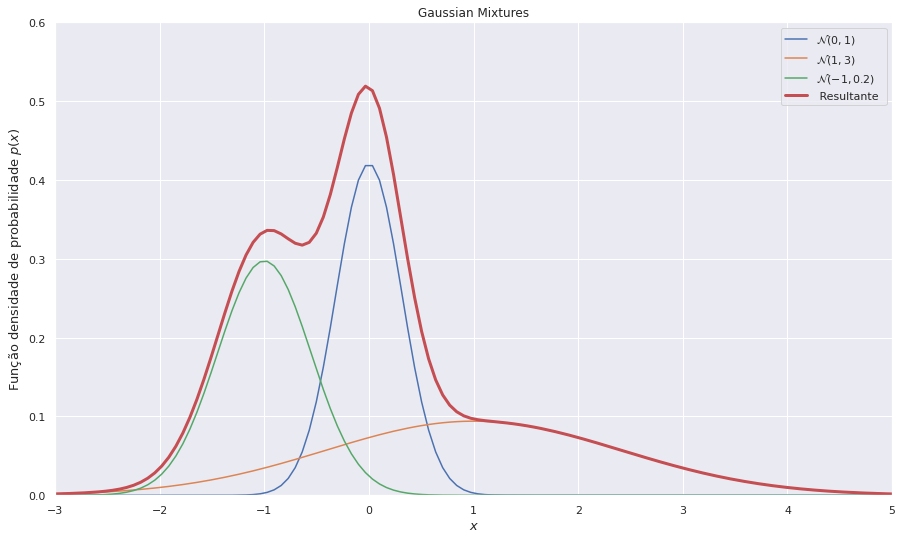

In [7]:
# Visualizando o comportamento da Normal - Gaussiana

# variável aleatória

x = np.linspace(-5, 5, num=150)

# Viisuaizando três valores diferentes de média e desvio padrão

y1 = Gaussiana_1D(x, mean=0, variance=0.1)
y2 = Gaussiana_1D(x, mean=1, variance=2)
y3 = Gaussiana_1D(x, mean=-1, variance=0.2)
y =  ( y1 + y2 + y3 )/3

fig = plt.figure(figsize=(15, 9))
plt.plot(
    x, y1/3, 
    label="$\mathcal{N}(0, 1)$")

plt.plot(
    x, y2/3, 
    label="$\mathcal{N}(1, 3)$")

plt.plot(
    x, y3/3, 
    label="$\mathcal{N}(-1, 0.2)$")

plt.plot(
    x, y, 
    label=" Resultante ",
    linewidth = "3")

# Complementos

plt.xlabel('$x$', fontsize=13)
plt.ylabel('Função densidade de probabilidade $p(x)$', fontsize=13)
plt.title('Gaussian Mixtures')
plt.ylim([0, 0.6])
plt.xlim([-3, 5])
plt.legend(loc=1)
fig.subplots_adjust(bottom=0.15)
plt.show()

## **Gerando dados - o caso bidimensional**

In [8]:
# Configurações básicas

d = 2 
mean = np.matrix([[0.], [1.]])
covariance = np.matrix([
    [1, 0.8], 
    [0.8, 1]
])

# Gerando os dados a partir da gaussiana

L = np.linalg.cholesky(covariance)

# gerando dados aleatórios a partir da gaussiana

n = 50  
X = np.random.normal(size=(d, n))

# Cria o vetor transformado

Y = L.dot(X) + mean

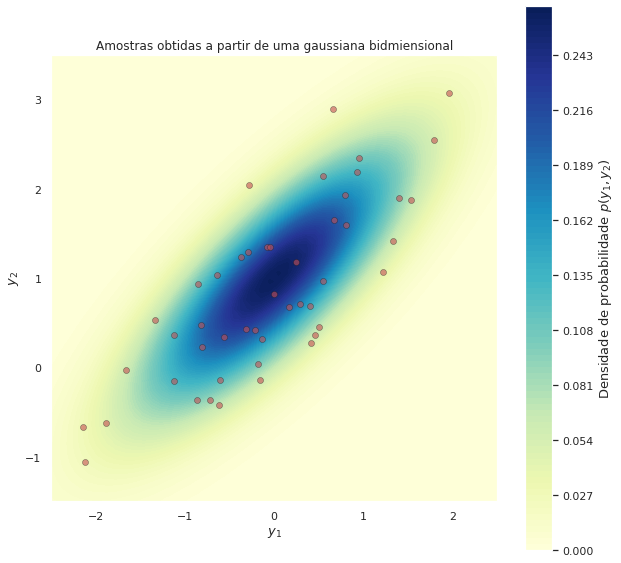

In [9]:
# Distribuição e pontos gerados para visualizaÇão comparativa

fig, ax = plt.subplots(figsize=(10, 10))
x1, x2, p = generate_surface(mean, covariance, d)
con = ax.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)

ax.plot(Y[0,:], Y[1,:], 'ro', alpha=.6,
        markeredgecolor='k', markeredgewidth=0.5)
ax.set_xlabel('$y_1$', fontsize=13)
ax.set_ylabel('$y_2$', fontsize=13)
ax.axis([-2.5, 2.5, -1.5, 3.5])
ax.set_aspect('equal')

ax.set_title('Amostras obtidas a partir de uma gaussiana bidmiensional')
cbar = plt.colorbar(con)
cbar.ax.set_ylabel('Densidade de probabilidade $p(y_1, y_2)$', fontsize=13)
plt.show()

## **Aprendendo**

### Selecionando um conjunto de dados

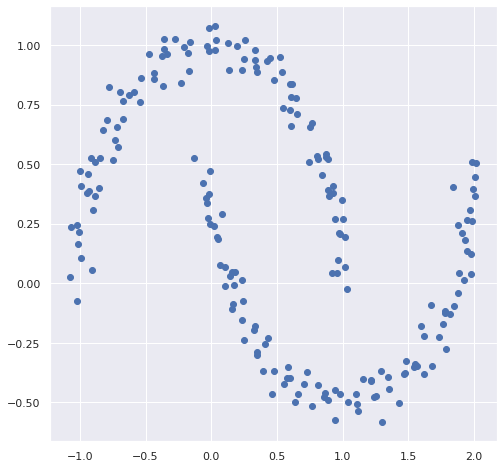

In [10]:
from sklearn.datasets import make_moons

plt.figure(figsize = (8,8))
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

### Ajustando os dados a um cojunto de 2 grupos (clusters)

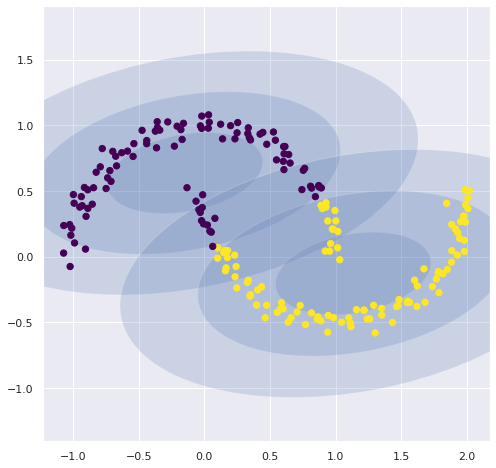

In [11]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plt.figure(figsize = (8,8))
plot_gmm(gmm2, Xmoon)

### Aumentando o número de agrupamentos

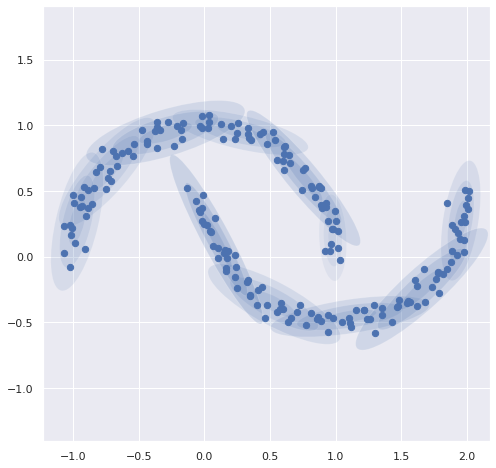

In [12]:
gmm11 = GaussianMixture(n_components=11, covariance_type='full', random_state=0)
plt.figure(figsize = (8,8))
plot_gmm(gmm11, Xmoon, label=False)

## Número de componentes - *model selection*

Quando ajustamos um conjunto de parâmetros $\theta$ em um modelo, geralmente, se aumentarmos o número de parâmetros, aumentamos a verossimilhança mas corre-se o risco de haver um *overfiting*. Os critérios AIC e BIC penalizam estas características e podem ser utilizados na sintonia do número de parâmetros $k$.

**onde:**

$\hat L =$ é o valor máximo da verossimilhança para um modelo M. $\hat L = p(x \vert \theta, M)$ e $\theta$ representa o cojunto de parâmetros que maximiza o verossimilhança.

$x - $ conjunto de dados observados.

$N - $ número de observações.

$k - $ número de parâmetros estimados.

### Akaike information criterion

$ \large \mathrm{AIC} = 2k - 2\ln(\hat L).$

### Bayesian information criterion - BIC

$ \large \mathrm{BIC} = k\ln(N) - 2\ln(\hat L).$






## Comparando os critérios

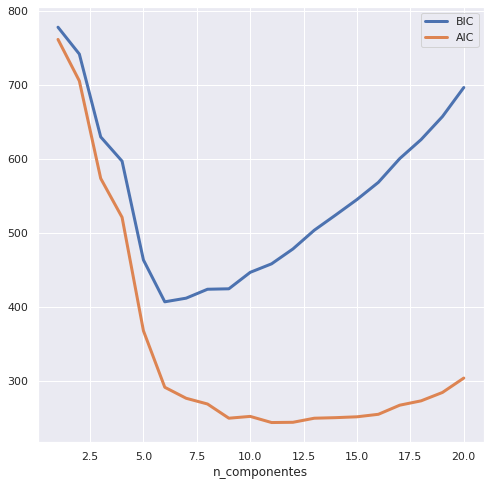

In [13]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]
plt.figure(figsize = (8,8))
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC',linewidth = "3")
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC',linewidth = "3")
plt.legend(loc='best')
plt.xlabel('n_componentes');

## **Um caso aplicado**

In [14]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

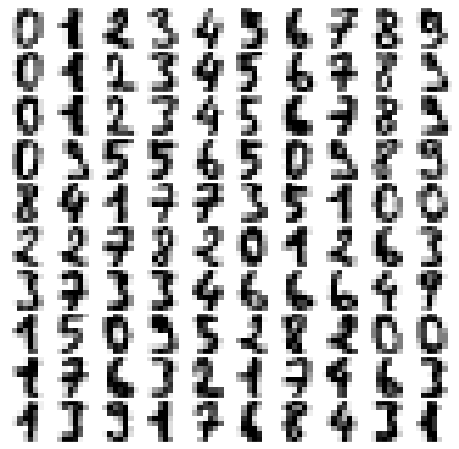

In [15]:
plot_digits(digits.data)

In [16]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

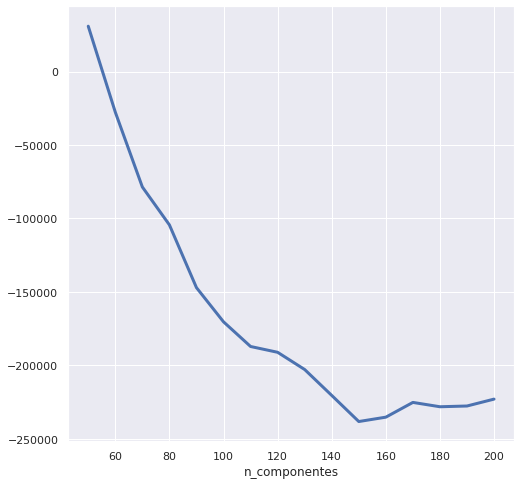

In [17]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
plt.figure(figsize = (8,8))
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics,linewidth = "3")
plt.xlabel('n_componentes')

In [18]:
gmm = GaussianMixture(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [19]:
data_new, labels = list(gmm.sample(100))
len(data_new)

100

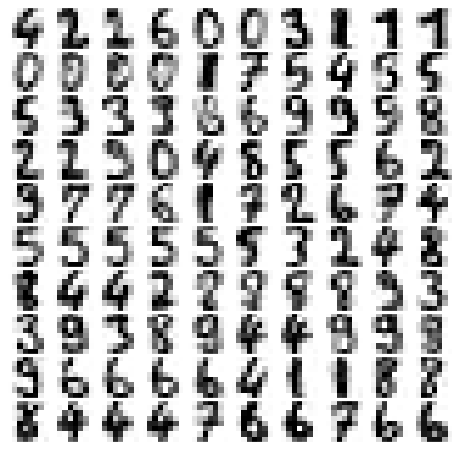

In [20]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

## **Referências**

In [ ]:
########################################################################################################
# Code source: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html        #
#                                                                                                      #
# Modified for class use and explanation about generative models by V.C.Parro                          #
#                                                                                                      #
# Data base: Native                                                                                    #
# License: BSD 3 clause                                                                                #
#                                                                                                      #
########################################################################################################

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

https://deepgenerativemodels.github.io/